In [1]:
from pandas import read_excel
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.mds_qlpdb import (
    QUBO_to_Ising,
    find_offset,
    AnnealOffset
)

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw

QUBO
[[-3.  8.  4. -4. -4. -8.  0.]
 [ 0. -5.  8. -4. -4. -8. -4.]
 [ 0.  0. -3.  0. -4. -8. -4.]
 [ 0.  0.  0.  6.  0.  0.  0.]
 [ 0.  0.  0.  0.  6.  8.  0.]
 [ 0.  0.  0.  0.  0. 16.  0.]
 [ 0.  0.  0.  0.  0.  0.  6.]]
Ising
[[ 0.  2.  1. -1. -1. -2.  0.]
 [ 0.  0.  2. -1. -1. -2. -1.]
 [ 0.  0.  0.  0. -1. -2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
[-2.5 -3.5 -2.5  1.   2.   4.   1. ]
100.0


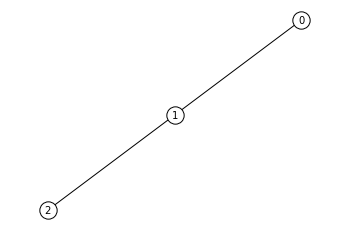

In [11]:
# brute force solving time-dependent schrodinger equation to simulate quantum annealing for small systems
graph, tag = gt.generate_nn_graph(3)
penalty = 2

annealing_time=0.1 #microseconds

offset = "binary"
offset_min = -0.05
offset_range = 0.1

solver_params = dict()
solver_params["method"] = "RK45"
solver_params["rtol"] = 1e-6
solver_params["atol"] = 1e-7


"""Start Program"""
# get qubo
directed = False
qubo = get_mds_qubo(
    graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
)
print("QUBO")
print(qubo.todense())

# number of qubits
n = len(qubo.todense())

# convert to Ising
Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())

#######################################################################################
#this is the unit conversion of energy/time (since we set time interval to be [0,1]) 
#######################################################################################

# assume annealing_time unit in microsecond and energy unit in Ghz
def energyscaleconversion(annealing_time):
    return annealing_time*1000.0

energyscale=energyscaleconversion(annealing_time)

print("Ising")
print(Jij)
print(hi)
print(energyscale)

# plot graph
gt.get_plot(graph, directed=directed)
plt.show()


In [12]:
# Get DWave anneal schedule
class s_to_offset():
    def __init__(self):
        params = {"kind":"linear", "fill_value":"extrapolate"} # linear makes for more sensible extrapolation.
        self.anneal_schedule = read_excel(io="./09-1212A-B_DW_2000Q_5_anneal_schedule.xlsx", sheet_name=1)
        self.interpC = interp1d(self.anneal_schedule["s"], self.anneal_schedule["C (normalized)"], **params)
        normA = self.anneal_schedule["A(s) (GHz)"]/self.anneal_schedule["A(s) (GHz)"].max()
        self.interpA = interp1d(self.anneal_schedule["C (normalized)"], normA, **params)
        normB = self.anneal_schedule["B(s) (GHz)"]/self.anneal_schedule["B(s) (GHz)"].max()
        self.interpB = interp1d(self.anneal_schedule["C (normalized)"], normB, **params)
    def sanity_check(self):
        # Sanity check: The data and interpolation should match
        # Interpolate C
        fig = plt.figure()
        ax = plt.axes()
        x = np.linspace(0, 1)
        ax.errorbar(x=self.anneal_schedule["s"], y=self.anneal_schedule["C (normalized)"])
        ax.errorbar(x=x, y=self.interpC(x))
        plt.draw()
        plt.show()
        # Interpolate A and B
        fig = plt.figure()
        ax = plt.axes()
        x = np.linspace(-0.05, 1.05)
        ax.errorbar(x=self.anneal_schedule["s"], y=self.anneal_schedule["A(s) (GHz)"]/self.anneal_schedule["A(s) (GHz)"].max())
        ax.errorbar(x=x, y=self.interpA(self.interpC(x)))
        ax.errorbar(x=self.anneal_schedule["s"], y=self.anneal_schedule["B(s) (GHz)"]/self.anneal_schedule["B(s) (GHz)"].max())
        ax.errorbar(x=x, y=self.interpB(self.interpC(x)))
        plt.draw()
        plt.show()

#s_to_offset().sanity_check()        

class AnnealSchedule():
    def __init__(self, offset, h):
        AO = AnnealOffset(offset)
        self.offset_list, self.offset_tag = AO.fcn(h, offset_min, offset_range)
        self.s2o = s_to_offset()
    def C(self, s):
        C = self.s2o.interpC(s)
        C_offset = C+self.offset_list
        return C_offset
    def A(self, s):
        C = self.C(s)
        return self.s2o.interpA(C)
    def B(self, s):
        C = self.C(s)
        return self.s2o.interpB(C)

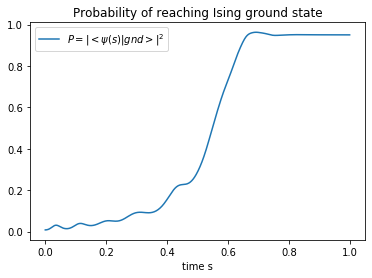

In [13]:
# pauli matrices
sigx=np.zeros((2,2))
sigz=np.zeros((2,2))
id2=np.identity(2)

sigx[0,1]=1.0
sigx[1,0]=1.0
sigz[0,0]=1.0
sigz[1,1]=-1.0

# offsets
AS = AnnealSchedule(offset, hi)

# push local operator to many body Fock space
def pushtoFock(i,local,n):
    fock=np.identity(1)
    for j in range(n):
        if (j==i):
            fock=np.kron(fock,local)            
        else:
            fock=np.kron(fock,id2)
    return fock


#print(pushtoFock(2,sigz,n))

# hamiltonian (Jij is i>j , i.e., lower diagonal)
def constructIsingH(Jij,hi,n):
    IsingH=np.zeros((2**n,2**n))
    for i in range(n):
        temp=pushtoFock(i,sigz,n)
        IsingH+=hi[i]*temp
        for j in range(i):
            IsingH+=Jij[i,j]*np.dot(temp,pushtoFock(j,sigz,n))
    return IsingH


def constructtransverseH(hxi,n):
    transverseH=np.zeros((2**n,2**n))
    for i in range(n):
        transverseH+=hxi[i]*pushtoFock(i,sigx,n)
    return transverseH
IsingH=constructIsingH(Jij,hi,n)
#print(IsingH)
transverseH=constructtransverseH(np.ones((n)),n)

# annealing hamiltonian
def Bij(B):
    return np.asarray([[0.5*(B[i]+B[j]) for i in range(n)] for j in range(n)])

def annealingH(s):
    #H=energyscale*(-0.5*A(t)*transverseH+0.5*B(t)*IsingH) # annealing hamiltonian
    #H+=offsetH(t) # offsets
    AxtransverseH=constructtransverseH(AS.A(s)*np.ones((n)),n)
    BxIsingH=constructIsingH(Bij(AS.B(s))*Jij,AS.B(s)*hi,n)
    H=energyscale*(-0.5*AxtransverseH+0.5*BxIsingH)
    return H

# define time-dependent schrodinger equation
def tdse(t,y):
    f=-1j*np.dot(annealingH(t),y)
    return f

# initial state
xev=np.asarray([1.0/np.sqrt(2.0),1.0/np.sqrt(2.0)])
y0=xev[:]
for i in range(n-1):
    y0=np.kron(xev,y0)
y0=(1.0+0.0j)*y0 #ensure complex dtype
#print('initial state',y0)

# solve ode
sol=solve_ivp(tdse, [0.0, 1.0], y0, **solver_params)

#print('ode solution')
#for i in range(sol.t.size):
#    print('time',i,'=',sol.t[i])
#    print(sol.y[:,i])


# brute force diagonalization Ising hamiltonain

energy,eigv=np.linalg.eigh(IsingH)
#print('brute force Ising')
#print('eigen envergy',energy)
#print('eigen vector')
#print(eigv)

# plot probability overlap with Ising ground state
overlap=np.zeros(sol.t.size)
for i in range(sol.t.size):
    overlap[i]=np.absolute(np.dot(eigv[:,0],sol.y[:,i]))**2


plt.plot(sol.t,overlap)
plt.legend([r'$P= |<\psi (s) | gnd >|^2$'])
plt.xlabel('time s')
plt.title('Probability of reaching Ising ground state')
plt.show()